In [8]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_algorithms import AmplificationProblem, Grover
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
from math import pi
from utils import get_image_path

In [9]:
def simulate(qc):
    backend = AerSimulator()
    transpiled_circuit = transpile(qc, backend)
    result = backend.run(transpiled_circuit, shots=1000).result().get_counts()
    display(plot_histogram(result))
    return result

In [10]:
def get_oracle(n, values):
    oracle = QuantumCircuit(n, name="oracle")
    
    print('---Embedding values---')
    good_states = []
    
    for value in values:
        bit_string = format(value, 'b').zfill(n)
        good_states.append(bit_string)
        print(value, ' - ', bit_string)
        bit_string = bit_string[::-1]
        
        zeros = [index for index, bit in enumerate(bit_string) if bit == '0']
        
        oracle.x(zeros)
        oracle.mcp(pi, list(range(1, n)), 0)
        oracle.x(zeros)
        
    return (oracle, good_states)    

---Embedding values---
0  -  000
1  -  001


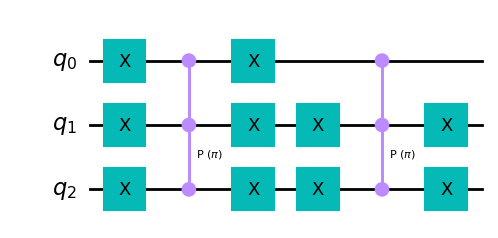

In [11]:
n = 3
oracle, good_states = get_oracle(n, [0, 1])
oracle.draw('mpl')

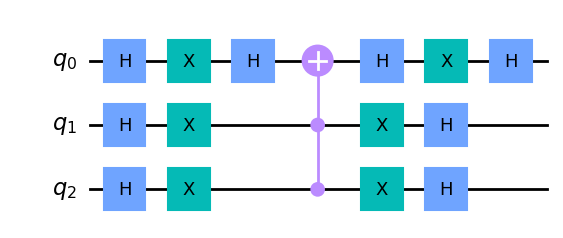

In [18]:
def get_diffuser(n):
    qubits_mapper = range(n)
    qc = QuantumCircuit(n, name="diffuser")
    qc.h(qubits_mapper)
    qc.x(qubits_mapper)
    qc.h(0)
    qc.mct(list(range(1, n)), 0)
    qc.h(0)
    qc.x(qubits_mapper)
    qc.h(qubits_mapper)
    return qc

diffuser = get_diffuser(n)
diffuser.draw('mpl')

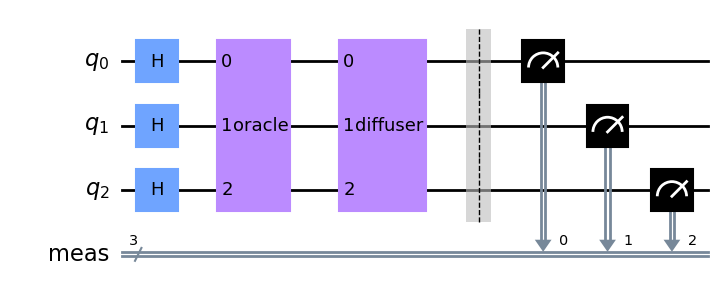

In [19]:
grover = QuantumCircuit(n)
grover.h(range(n))
grover.append(oracle, range(n))
grover.append(diffuser, range(n))
grover.measure_all()
grover.draw('mpl', filename=get_image_path("grover.png"))

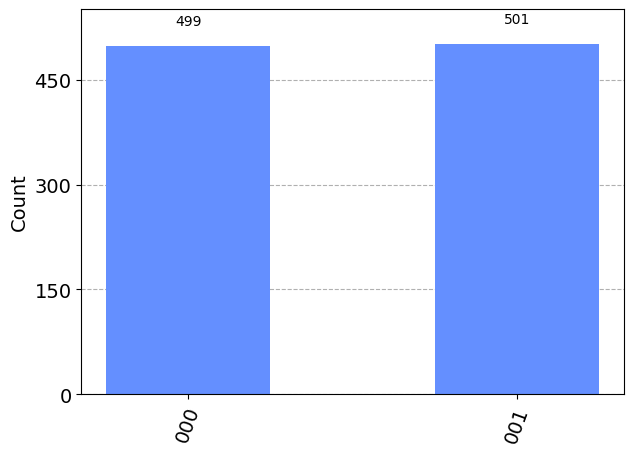

{'001': 501, '000': 499}

In [20]:
simulate(grover)

---

In [ ]:
problem = AmplificationProblem(oracle=oracle, is_good_state=good_states)
display(problem.grover_operator.decompose().draw('mpl'))
grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
print(f'evaluated: {result.oracle_evaluation}')

In [ ]:
plot_histogram(result.circuit_results)